In [60]:
import pandas as pd
import lightgbm as lgb
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings

warnings.filterwarnings("ignore")

In [61]:
data = pd.read_csv(r'D:\AI_Risk-master\AI_Risk-master\best_data.csv')

In [21]:
data=data[data.target!=2]
X=traindata.iloc[:,5:]
Y=traindata.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=88)

In [22]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_test = lgb.Dataset(X_train, Y_test)

In [23]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'auc'},
    'num_leaves': 36,
    'learning_rate': 0.01,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.7,
    'random_state':1024,
}
print('Start training...')
# train
gbm = lgb.train(params,  lgb_train,  num_boost_round=950
               )

print('Start predict...')

Start training...
Start predict...


In [34]:
test_y_pred = gbm.predict(X_test)

get_ks = lambda y_pred, y_true: ks_2samp(y_pred[y_true == 1], y_pred[y_true != 1]).statistic

test_ks = get_ks(test_y_pred, Y_test)
test_auc = roc_auc_score(Y_test,test_y_pred)

print('test_ks: %s' %test_ks)
print('test_auc: %s' %test_auc)

test_ks: 0.5664642133968835
test_auc: 0.8557670350100204


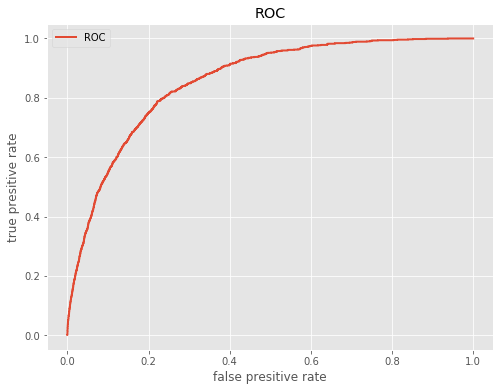

In [42]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.title('ROC')
plt.legend()

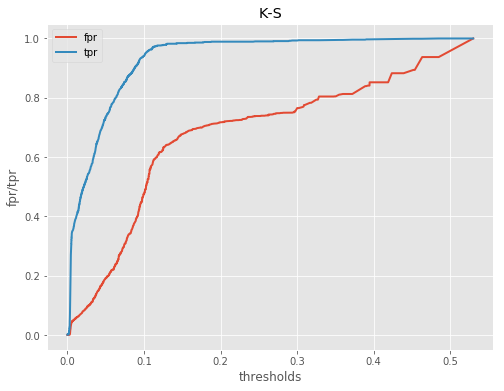

In [43]:
plt.figure(figsize=(8,6))
plt.plot(sorted(thresholds),fpr,linewidth=2,label="fpr")
plt.plot(sorted(thresholds),tpr,linewidth=2,label="tpr")
plt.xlabel("thresholds")
plt.ylabel("fpr/tpr")
plt.title('K-S')
plt.legend()

In [90]:
test = pd.DataFrame(test_y_pred, index=Y_test.index)
test.columns = ['proba_1']
dfrank2 = pd.DataFrame(columns=["proba_1", "rank", "target"])
score = []
parts = [i for i in range(1,11)]
p = 10

In [91]:
for i in range(10):
    if i == 0:
        dfrank1 = test.loc[(test.proba_1 <= test.proba_1.quantile(parts[i] / p)) & (test.proba_1 >= 0), :]
        dfrank1['rank'] = i + 1
        dfrank2 = dfrank2.append(dfrank1)
        score.append(dfrank.proba_1.quantile(parts[i] / p))
    elif i == len(parts) - 1:
        dfrank1 = test.loc[(test.proba_1 <= test.proba_1.quantile(parts[i] / p)) & (
                test.proba_1 > dfrank.proba_1.quantile(parts[i-1] / p)), :]
        dfrank1['rank'] = i + 1
        dfrank2 = dfrank2.append(dfrank1)
        score.append(dfrank.proba_1.quantile(parts[i] / p))
    else:
        dfrank1 = test.loc[(test.proba_1 <= test.proba_1.quantile(parts[i] / p)) & (
                test.proba_1 > dfrank.proba_1.quantile(parts[i-1] / p)), :]
        dfrank1['rank'] = i + 1
        dfrank2 = dfrank2.append(dfrank1)
        score.append(dfrank.proba_1.quantile(parts[i] / p))

In [93]:
dfrank2['target'] = Y_test

rk1 = dfrank2.groupby('rank').count()[['proba_1']]
rk1.rename(columns={'proba_1': '总数'}, inplace=True)
rk2 = dfrank2.groupby('rank').apply(lambda x: x[['target']].sum())[['target']]
rk2.rename(columns={'target': '目标数'}, inplace=True)
rk3 = dfrank2.groupby('rank').apply(lambda x: x.count() / len(dfrank2))[['rank']]
rk3.rename(columns={'rank': '分组占比'}, inplace=True)
rk4 = dfrank2.groupby('rank').apply(lambda x: x[['target']].sum() / x[['target']].count())[['target']]
rk4.rename(columns={'target': '目标占比'}, inplace=True)

In [94]:
result = pd.concat([rk1, rk2, rk3, rk4], axis=1)
result['score'] = score
result

,总数,目标数,分组占比,目标占比,score
rank,,,,,
1,3628,1,0.100003,0.000276,0.001588
2,3628,5,0.100003,0.001378,0.002629
3,3628,9,0.100003,0.002481,0.003780
4,3628,14,0.100003,0.003859,0.005330
5,3628,24,0.100003,0.006615,0.008960
6,3627,42,0.099975,0.011580,0.015589
7,3628,68,0.100003,0.018743,0.025126
8,3628,118,0.100003,0.032525,0.038933
9,3628,206,0.100003,0.056781,0.073192


In [95]:
sum(Y_test)/len(Y_test)

0.027922489594531273